In [1]:
"""Import everything we need and check gpu"""

%matplotlib inline

already_installed = !pip list -v | grep deeptrack
if not already_installed:
    !pip install deeptrack==0.11.3

import numpy as np
import matplotlib.pyplot as plt
import deeptrack as dt
import scipy.io as IO
import keras.backend as K
import keras.optimizers as optimizers
import os
from matplotlib import image
from keras.layers import Layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import files
from cycler import cycler
from numpy.fft import fft2, ifft2, fftshift
from matplotlib import colors


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Feb  4 10:24:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
"""Define optics, note that crop is disabled but should probably be used when we know how it works."""

IMAGE_SIZE = 256
NUMBER_OF_PARTICLES = 50 #in 1400x1200 picture, said to be up to 60.
NUMBER_OF_PARTICLES = round(256*256/(1400*1200)*NUMBER_OF_PARTICLES)

particle = dt.MieSphere(
    position=lambda: (IMAGE_SIZE) * np.random.rand(2),
    z=lambda: -150 + np.random.random() * 300,
    radius=lambda: 1.5e-7 + 3e-7 * np.random.rand() ,
    refractive_index=lambda: np.random.uniform(0, 0.15) + 1.45,
    L=8,
    position_unit="pixel",
)

particle_middle = dt.MieSphere(
    position=lambda: (IMAGE_SIZE//2, IMAGE_SIZE//2),
    z=lambda: 99.99, #-150 + np.random.random() * 300,
    radius=lambda: 1.5e-7 + 3e-7 * np.random.rand() ,
    refractive_index=lambda: np.random.uniform(0, 0.15) + 1.45,
    L=8,
    position_unit="pixel",
)

HC = dt.HorizontalComa(coefficient=lambda c1: c1, c1=0 + np.random.randn() * 0.05)
VC = dt.VerticalComa(coefficient=lambda c2:c2, c2=0 + np.random.randn() * 0.05)

def crop(pupil_radius):
    def inner(image):
        x = np.arange(image.shape[0]) - image.shape[0] / 2
        y = np.arange(image.shape[1]) - image.shape[1] / 2
        X, Y = np.meshgrid(x, y)
        image[X ** 2 + Y ** 2 > pupil_radius ** 2] = 0
        return image
    return inner
CROP = dt.Lambda(crop, pupil_radius=23)

optics = dt.Brightfield(
    NA=1.3,
    resolution=1.13e-6,
    wavelength=635e-9,
    aperature_angle=53.7 * 2 * np.pi / 360,
    polarization_angle=lambda: np.random.rand() * 2 * np.pi,
    magnification=10,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    padding=(64,) * 4,
    return_field=True,
    pupil=HC+VC# + CROP,         ###crop() behaves strangely when IMAGE_SIZE is changed.
)

real_noise = dt.Gaussian(
    mu=0, 
    sigma=lambda level: np.random.rand() * 0.01*0,
)

noise = real_noise + dt.Gaussian(
    mu=0, 
    sigma=lambda real_sigma: real_sigma * 0.01j*0,
    real_sigma=real_noise.sigma
)

gradient = dt.IlluminationGradient(
    gradient=lambda: np.random.randn(2) * 5e-6*0,
)



/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


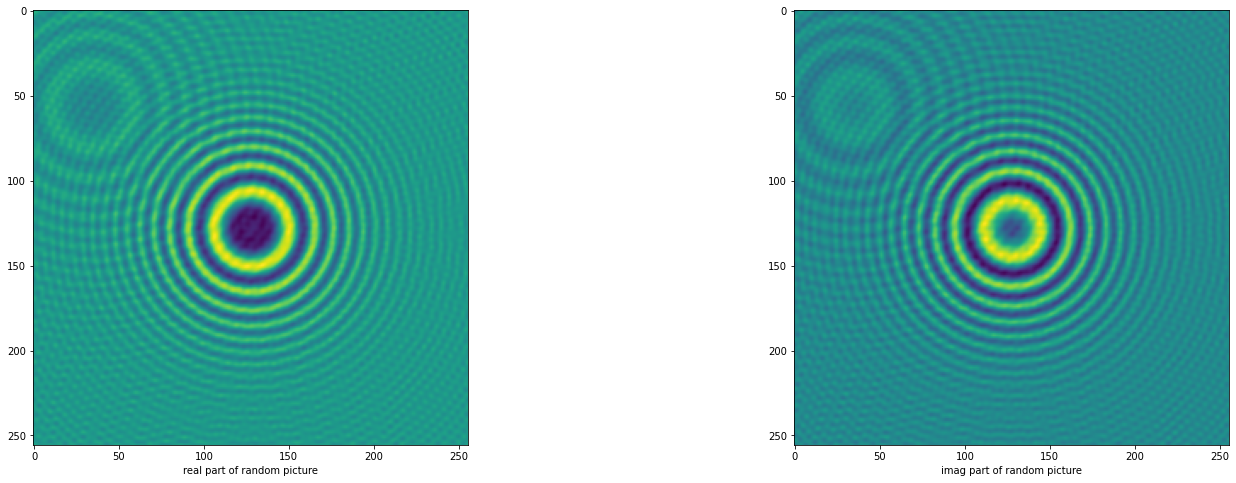

In [3]:
"""Visualizing the particles and creating the dataset"""

def func():
    def inner(image):
        image = (image - 1)
        output = np.zeros((*image.shape[:2], 2))
        output[..., 0:1] = np.real(image)
        output[..., 1:2] = np.imag(image)
        return output
    return inner

def normalization_func():
    def inner(image):
        output = np.zeros((*image.shape[:2], 2))
        output[:,:,0] = image[:,:,0] - np.min(image[:,:,0])
        output[:,:,1] = image[:,:,1] - np.min(image[:,:,1])
        return output
    return inner

complex_to_float = dt.Lambda(func)

particles = particle ** (NUMBER_OF_PARTICLES)
dataset = optics(particle + particle_middle + noise + gradient) + complex_to_float
test_image = dataset.update().resolve()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,8))
ax1.imshow(test_image[:,:,0])
ax1.set_xlabel("real part of random picture")
ax2.imshow(test_image[:,:,1])
ax2.set_xlabel("imag part of random picture")
plt.show()

In [4]:
"""get_label returns the z position of the middle particle, but normalized to [0,1]"""

def get_label(image):
    return np.array([(image.get_property("z")+150)/300])

In [5]:
"""Define a bunch of models and put them in a list."""
models=[]
model= dt.models.Convolutional(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 2),
    convolution_layers_dimensions=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE),
    dense_layers_dimensions=(64, 32),
    steps_per_pooling=1,
    number_of_outputs=1,
    dropout=(0, 0),
    loss="mse",
    optimizer="adam",
    dense_block=dt.layers.DenseBlock(activation="sigmoid")
)
model.totalhistory = {"val_loss":[], "loss":[]}
model.specs={"convolution_layers_dimensions=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE) dense_layers_dimensions=(64, 32) sigmoid,"}
model.summary()
models.append(model)

model= dt.models.Convolutional(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 2),
    convolution_layers_dimensions=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE),
    dense_layers_dimensions=(64, 32),
    steps_per_pooling=1,
    number_of_outputs=1,
    dropout=(0, 0),
    loss="mse",
    optimizer="adam",
    dense_block=dt.layers.DenseBlock(activation="sigmoid")
)
model.totalhistory = {"val_loss":[], "loss":[]}
model.specs={"convolution_layers_dimensions=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE) dense_layers_dimensions=(64, 32) sigmoid,"}
model.summary()
models.append(model)

model= dt.models.Convolutional(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 2),
    convolution_layers_dimensions=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE),
    dense_layers_dimensions=(64, 32),
    steps_per_pooling=1,
    number_of_outputs=1,
    dropout=(0, 0),
    loss="mse",
    optimizer="adam",
    dense_block=dt.layers.DenseBlock(activation="relu")
)
model.totalhistory = {"val_loss":[], "loss":[]}
model.specs={"convolution_layers_dimensions=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE) dense_layers_dimensions=(64, 32) relu,"}
model.summary()
models.append(model)

model= dt.models.Convolutional(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 2),
    convolution_layers_dimensions=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE),
    dense_layers_dimensions=(64, 32),
    steps_per_pooling=1,
    number_of_outputs=1,
    dropout=(0, 0),
    loss="mse",
    optimizer="adam",
    dense_block=dt.layers.DenseBlock(activation="sigmoid")
)
model.totalhistory = {"val_loss":[], "loss":[]}
model.specs={"convolution_layers_dimensions=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE) dense_layers_dimensions=(64, 32) relu,"}
model.summary()
models.append(model)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 2)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      304       
                                                                 
 activation (Activation)     (None, 256, 256, 16)      0         
                                                                 
 spatial_dropout2d (SpatialD  (None, 256, 256, 16)     0         
 ropout2D)                                                       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640  

In [6]:
"""Fourier transform etc."""

def save_progress(h, validation_set, validation_labels, model, plot=True):
    model.totalhistory["val_loss"].extend(h.history["val_loss"])
    model.totalhistory["loss"].extend(h.history["loss"])            
    if plot:
        validation_predictions = model.predict(np.array(validation_set))
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,8))

        ax1.plot(model.totalhistory["val_loss"], 'g', label="validation loss")
        ax1.plot(model.totalhistory["loss"], 'b', label="training loss")
        ax1.set_xlabel("Epoch")
        ax1.set_yscale('log')
        ax1.legend()

        ax2.scatter(validation_predictions, validation_labels)
        ax2.plot(np.linspace(0,1),np.linspace(0,1),'k')
        ax2.set_xlabel("predicted z")
        ax2.set_ylabel("actual z")

        ax3.hist(300*np.array((validation_predictions-np.array(validation_labels))), bins=list(np.linspace(-10,10,100)))
        ax3.set_xlabel("Pixlar från faktiskt värde")

        ax4.imshow(validation_set[0][:,:,0])

        plt.show()

def plot_together(models):
    cc = (cycler(color=list('bgrcmykbgrcmykbgrcmykbgrcmyk')) +
      cycler(linestyle=['-','-','-','-','-','-','-','--','--','--','--','--','--','--','-.','-.','-.','-.','-.','-.','-.',':',':',':',':',':',':',':']))
    
    fig, ax = plt.subplots(1,1,figsize=(15,15))
    ax.set_prop_cycle(cc)
    for i, model in enumerate(models):
        ax.plot(model.totalhistory["val_loss"], label=f"Model {i}, {model.specs}")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Validation loss")
        ax.set_yscale("log")
        ax.legend()

    ax.grid(True)
    plt.show()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


Generating 129 / 128 samples before starting training
Model: {'convolution_layers_dimensions=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE) dense_layers_dimensions=(64, 32) sigmoid,'}


/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


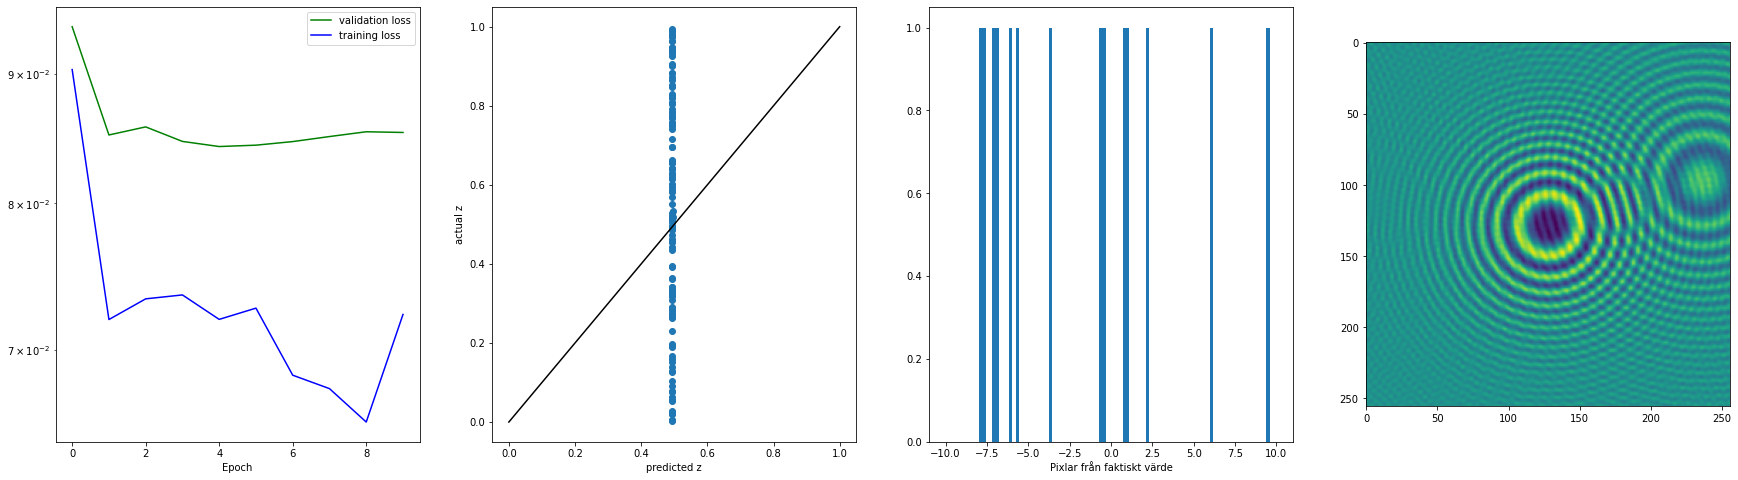

Model: {'convolution_layers_dimensions=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE) dense_layers_dimensions=(64, 32) sigmoid,'}


/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


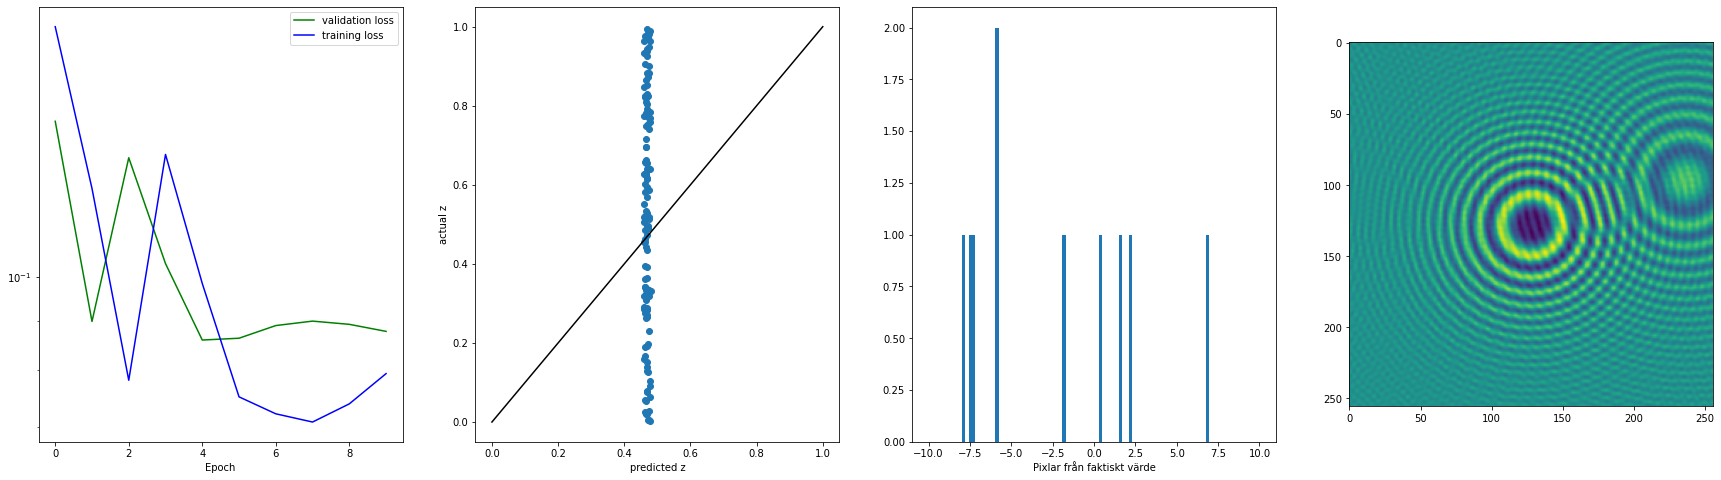

Model: {'convolution_layers_dimensions=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE) dense_layers_dimensions=(64, 32) relu,'}


/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


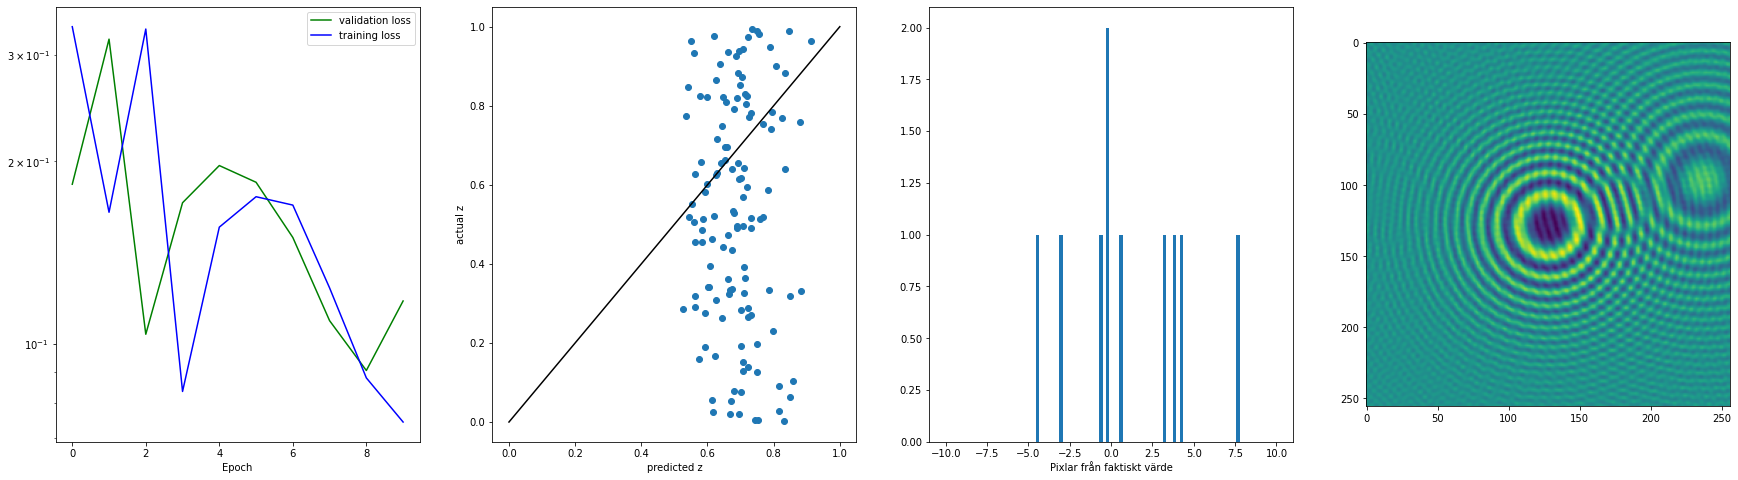

Model: {'convolution_layers_dimensions=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE) dense_layers_dimensions=(64, 32) relu,'}


/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


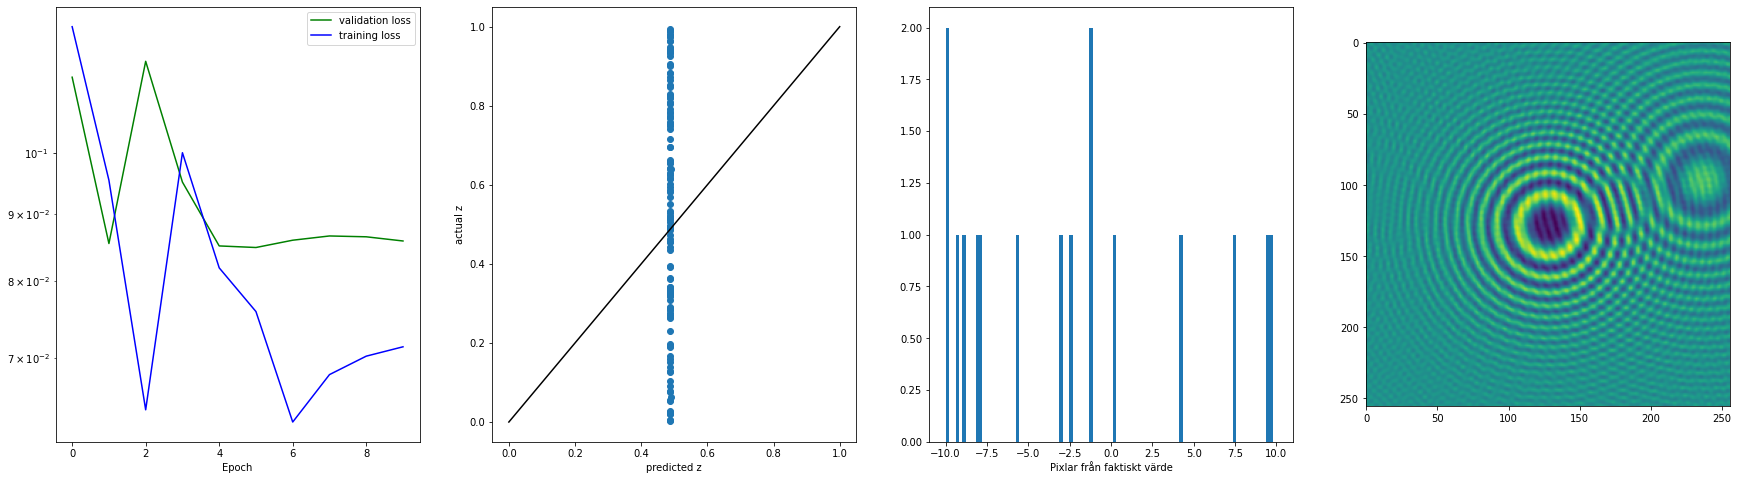

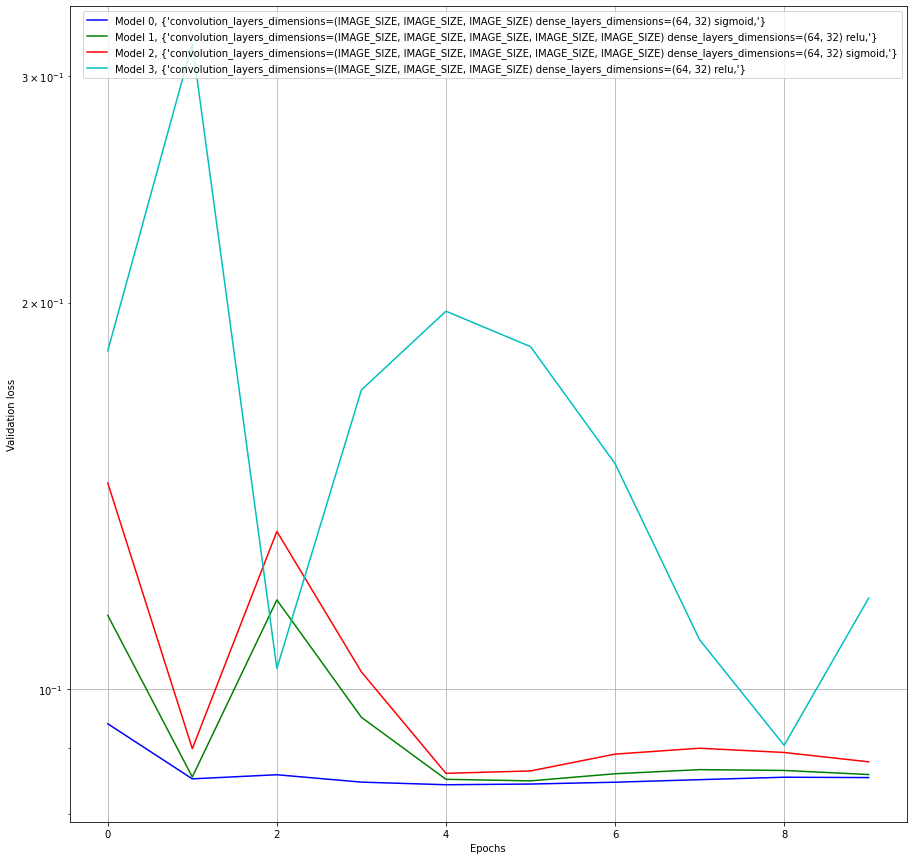

Generating 220 / 128 samples before starting training
Model: {'convolution_layers_dimensions=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE) dense_layers_dimensions=(64, 32) sigmoid,'}


/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


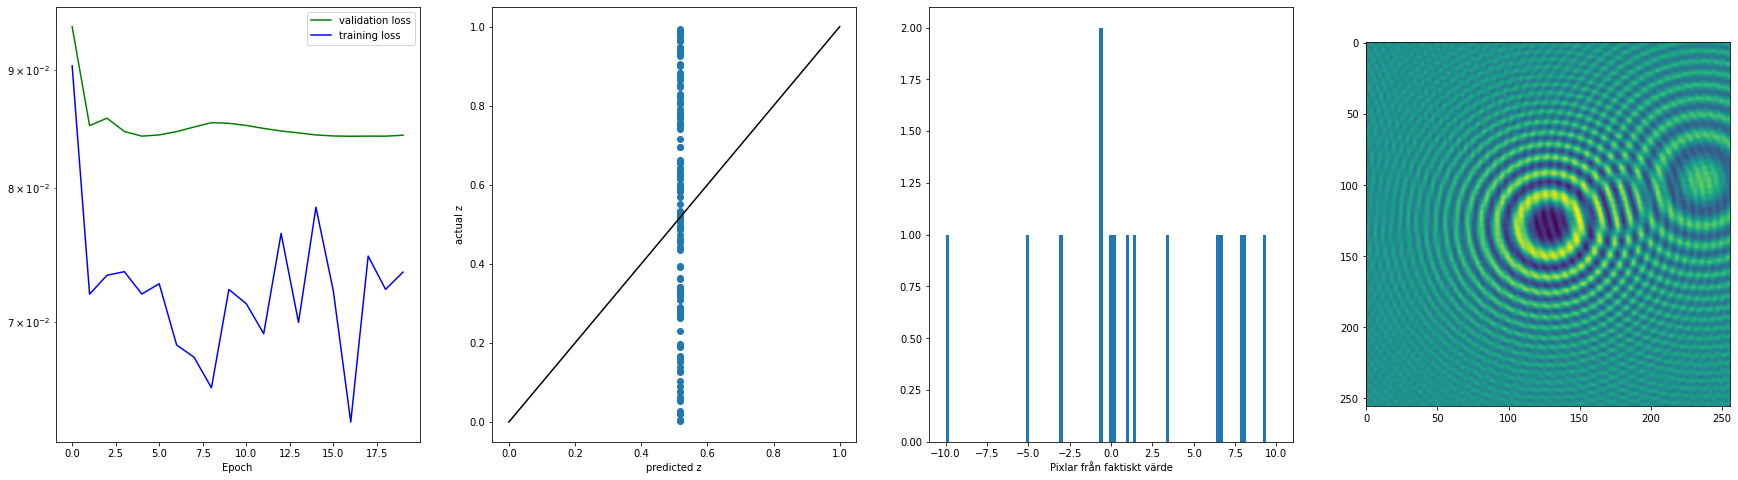

KeyboardInterrupt: ignored

In [7]:
"""Training all the models"""
validation_set_size = 128
validation_set = [dataset.update().resolve() for _ in range(validation_set_size)]
validation_labels = [get_label(image) for image in validation_set]


generator = dt.generators.ContinuousGenerator(
    dataset,
    get_label,
    min_data_size=128,
    max_data_size=256,
    batch_size=128,
)
for _ in range(150):
    with generator:
        for model in models:
            h = model.fit(
                generator,
                validation_data=(
                    np.array(validation_set), 
                    np.array(validation_labels)
                ),
                epochs=10,
                verbose=0,
            )
            print(f'Model:', model.specs)
            save_progress(h, validation_set, validation_labels, model, plot=True)
        models.sort(key=lambda x: x.totalhistory["val_loss"][-1])
        plot_together(models)